In [1]:
import top_k
import numpy as np
import pandas as pd

# Namaak benade 2018

In [3]:
# using project costs and utils from benade 2018
P = 10
budget = 65

project_prizes= {0:10, 1:20, 2:3, 3:8, 4:5, 5:5, 6:10, 7:10, 8:30, 9:25}
possible_sets = top_k.get_possible_sets(project_prizes, budget)

In [ ]:
N = 720
epsilon = 15

base_util = np.asarray([5.8, 2.3, 29.3, 9.5, 14.8, 9.4, 5.4, 14.9, 6.7, 1.9])
utilities = top_k.make_voter_utils(base_util, epsilon, N)

In [4]:
max_set = top_k.max_utility(possible_sets, utilities)


NameError: name 'possible_sets' is not defined

In [5]:
for k in range(1, P):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(votes)
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, project_prizes)
        dist_score = top_k.calc_dist_score(winners, max_set, utilities)

#         print("util", util_score)
#         print("egal", egal_score)
#         print("comp", comp_score)
#         print("dist", dist_score)

NameError: name 'P' is not defined

In [6]:
df = pd.read_csv("results/results_P10_ep15_N720_B65_min10_max25_L100.csv")

FileNotFoundError: [Errno 2] File results/results_P10_ep15_N720_B65_min10_max25_L100.csv does not exist: 'results/results_P10_ep15_N720_B65_min10_max25_L100.csv'

In [7]:
from collections import Counter
from matplotlib import pyplot as plt

winners = []
for i, row in df.iterrows():
    win = []
    for i in range(1,10):
        get = "k_" + str(i) + "_winners"
        win.append(int(row[get]))
    winners.append(win)
    
winner_sets = []
for i, result in enumerate(winners):
    winner_sets.append(len(set(result)))
    
c = Counter(winner_sets)
plt.bar(list(c.keys()), c.values())
plt.xlabel("Different winning sets")
plt.ylabel("Runs")
plt.show()

NameError: name 'df' is not defined

# Epistemic accuracy

In [2]:
from collections import defaultdict
from sklearn.preprocessing import normalize


def epistemic_topk(probs, k, N):
    votes = []
    projects = list(range(len(probs)))
    # Create noisy prob vectors for voters
    probs = np.tile(probs, (N,1))
    noise = np.random.normal(0.07, 0.05, (N, len(projects)))
    probs += noise
    # Set all negative probs to positive number and 
    probs[probs < 0] = 0.0001
    probs = normalize(probs, "l1", axis=1)
    # Every voters uses prob distr to vote
    for i in range(N):
        vote = np.random.choice(projects, k, replace=False, p=probs[i])
        votes += list(vote)
    return Counter(votes)


In [9]:
P = 10 
epsilon = 10
N = 500
budget = 40
min_prize = 5
max_prize = 25

In [10]:
values = top_k.make_base_util(P)
probs = values / np.sum(values)
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
best_set = top_k.best_outcome(values, possible_sets)

In [11]:
utilities = top_k.make_voter_utils(values, epsilon, N)


In [12]:
for k in range(1, P):
    print("---------k------------", k)
    # calculate scores for all projects
    votes = epistemic_topk(probs, k,  N)
    print(votes)
    
    # determine the winning projects
    winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
    # Epistemic accuracy
    print("win:", list(winners), "--best",  best_set[0])
    correct = 0
    for alt in list(winners):
        if alt in best_set[0]:
            correct += 1
    
    acc = correct/len(best_set[0])
    print(acc)
                


---------k------------ 1
Counter({8: 96, 9: 93, 0: 88, 1: 62, 5: 43, 3: 31, 7: 25, 6: 23, 4: 22, 2: 17})


NameError: name 'project_prizes' is not defined

# Different base utils

In [77]:
P = 10
epsilon = 10
N = 500
budget = 40
min_prize = 5
max_prize = 15

In [78]:
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
# best_set = top_k.best_outcome(values, possible_sets)
max_set, max_total_util = top_k.max_utility(possible_sets, utilities)

In [79]:
# Create different base utilities 
base_util, vote_util = [], []
for i in range(P):
    util = top_k.make_base_util(P)
    base_util.append(util)    
    utilities = top_k.make_voter_utils(util, epsilon, int(N/5))
    vote_util.append(utilities)
voter_utilities = np.vstack(vote_util)

In [80]:
util_scores = []
egal_scores = []
comp_scores = []
dist_scores = []


for k in range(1, P+1):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, voter_utilities, P)
        print(f"votes: {votes}")
        
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, prizes, budget)
        print(winners)
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, prizes)
        dist_score = max_total_util / util_score

        print("util", util_score)
        print("egal", egal_score)
        print("comp", comp_score)
        print("dist", dist_score)
        
        util_scores.append(util_score)
        egal_scores.append(egal_score)
        comp_scores.append(comp_score)
        dist_scores.append(dist_score)

---------k------------ 1
votes: Counter({7: 131, 0: 123, 4: 110, 8: 109, 9: 98, 3: 92, 5: 89, 2: 87, 1: 87, 6: 74})
{0, 1, 4, 7, 8}
util 0.4942307788224738
egal 0.20123959160478366
comp 20.67
dist 99.13572165070822
---------k------------ 2
votes: Counter({7: 262, 0: 234, 8: 211, 5: 201, 4: 199, 1: 196, 9: 191, 2: 178, 3: 170, 6: 158})
{0, 8, 5, 7}
util 0.34104469360318945
egal 0.07994072944042205
comp 17.0
dist 143.66423474562248
---------k------------ 3
votes: Counter({7: 382, 0: 341, 8: 314, 4: 304, 5: 303, 1: 285, 9: 278, 3: 272, 2: 265, 6: 256})
{0, 1, 4, 7, 8}
util 0.4942307788224738
egal 0.20123959160478366
comp 20.67
dist 99.13572165070822
---------k------------ 4
votes: Counter({7: 484, 0: 442, 4: 411, 8: 411, 5: 410, 1: 382, 3: 374, 2: 373, 9: 362, 6: 351})
{0, 1, 4, 7, 8}
util 0.4942307788224738
egal 0.20123959160478366
comp 20.67
dist 99.13572165070822
---------k------------ 5
votes: Counter({7: 569, 0: 556, 8: 527, 5: 503, 1: 501, 4: 500, 2: 476, 9: 465, 3: 463, 6: 440})
{0

In [81]:
from matplotlib import pyplot as plt

def plot(name, scores):
    x = range(1, P+1)
    plt.bar(x, scores)

    plt.title(name, fontsize=20)
    plt.xticks(range(1,10))

    plt.xlabel("k-value", fontsize=15)
    plt.ylabel("score", fontsize=15)
    plt.show()

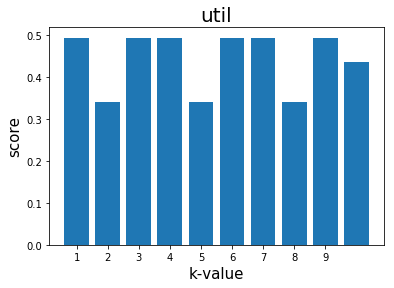

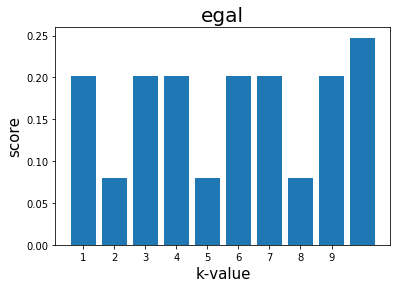

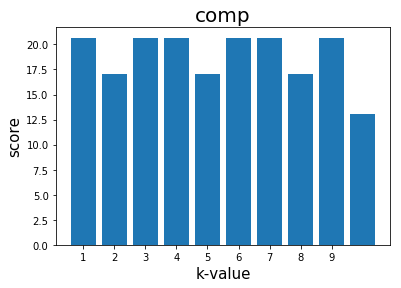

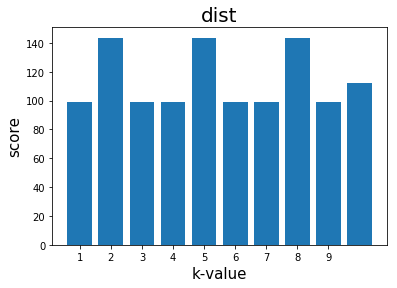

In [82]:
plot("util", util_scores)
plot("egal", egal_scores)
plot("comp", comp_scores)
plot("dist", dist_scores)

# Borda base util

In [3]:
P = 10
epsilon = 5
N = 500
budget = 30
min_prize = 20
max_prize = 30

In [4]:
def normal_prizes(min_prize, max_prize, sd, P):
    prizes = {}
    mid = (min_prize+sd)
    for i in range(P):
        prize = np.random.normal(mid, sd)
        prizes[i] = int(max(prize, min_prize))
    return prizes

In [5]:
# Create utilities
base_util = top_k.make_base_util(P, True)
base_util[0] = 30
base_util[1:] = 2
print(base_util)
utilities = top_k.make_voter_utils(base_util, epsilon, N)
print(utilities)
# Prizes and possible sets
prizes = top_k.make_projects(min_prize, max_prize, P)
# prizes = normal_prizes(min_prize, max_prize, 7, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
max_set, max_total_util = top_k.max_utility(possible_sets, utilities)


[30  2  2  2  2  2  2  2  2  2]
[[0.4122826  0.06786708 0.         ... 0.03029138 0.15841548 0.14937762]
 [0.30296475 0.07962356 0.11197145 ... 0.12462072 0.0865863  0.03342368]
 [0.62006144 0.07367359 0.         ... 0.0066114  0.0013173  0.08254214]
 ...
 [0.4808159  0.06273759 0.02017207 ... 0.12123369 0.07390803 0.07626211]
 [0.2516049  0.         0.07859085 ... 0.10867549 0.063678   0.04988784]
 [0.35414134 0.11575128 0.11015943 ... 0.06067553 0.         0.06013068]]


In [6]:
util_scores = []
egal_scores = []
comp_scores = []
dist_scores = []


for k in range(1, P+1):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(f"votes: {votes}")
        
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, prizes, budget)
        print(winners)
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, prizes)
        dist_score = max_total_util / util_score

        print("util", util_score)
        print("egal", egal_score)
        print("comp", comp_score)
        print("dist", dist_score)
        
        util_scores.append(util_score)
        egal_scores.append(egal_score)
        comp_scores.append(comp_score)
        dist_scores.append(dist_score)

---------k------------ 1
votes: Counter({3: 60, 2: 59, 9: 59, 8: 58, 7: 56, 4: 56, 1: 55, 5: 49, 6: 48, 0: 0})
{3}
util 0.06925705823224791
egal 0.0
comp 0.0
dist 2585.3962219909718
---------k------------ 2
votes: Counter({8: 118, 4: 118, 2: 117, 3: 114, 1: 108, 7: 108, 5: 107, 9: 106, 6: 104, 0: 0})
{8}
util 0.07028952082968055
egal 0.0
comp 0.0
dist 2547.4200789295132
---------k------------ 3
votes: Counter({8: 181, 4: 172, 6: 171, 3: 168, 2: 165, 9: 163, 5: 163, 1: 163, 7: 154, 0: 0})
{8}
util 0.07028952082968055
egal 0.0
comp 0.0
dist 2547.4200789295132
---------k------------ 4
votes: Counter({6: 235, 8: 230, 2: 228, 3: 228, 4: 221, 9: 220, 5: 214, 1: 214, 7: 210, 0: 0})
{6}
util 0.06950140172391156
egal 0.0
comp 0.0
dist 2576.3068407044657
---------k------------ 5
votes: Counter({6: 292, 3: 285, 8: 283, 4: 278, 9: 276, 2: 275, 5: 274, 7: 269, 1: 268, 0: 0})
{6}
util 0.06950140172391156
egal 0.0
comp 0.0
dist 2576.3068407044657
---------k------------ 6
votes: Counter({6: 352, 3: 34

In [61]:
from matplotlib import pyplot as plt

def plot(name, scores):
    x = range(1, P+1)
    plt.bar(x, scores)

    plt.title(name, fontsize=20)
    plt.xticks(range(1,10))

    plt.xlabel("k-value", fontsize=15)
    plt.ylabel("score", fontsize=15)
    plt.show()

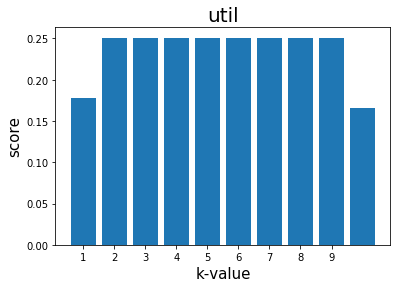

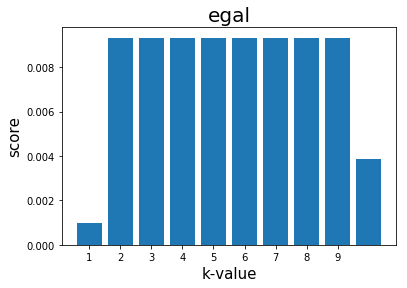

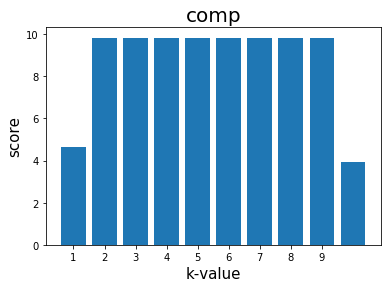

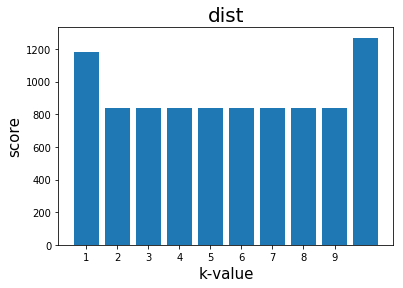

In [62]:
plot("util", util_scores)
plot("egal", egal_scores)
plot("comp", comp_scores)
plot("dist", dist_scores)